In [900]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import optperfprofpy

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [1366]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
                 usecols=lambda col: col not in ['d_vlt'])

In [1367]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [1835]:
o0['IS_over_mean_56'] = (o0['initial_stock_overall'] / o0['mean_56']).replace(np.inf, 0).fillna(0)
o0['overall_opt_order_for_opt'] = o0['overall_opt_order'].copy()

In [1825]:
o1 = o0.copy()

In [1838]:
# o1.insert(1, 'sku_id', o1['item_sku_id'])
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [1839]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [1840]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.9, test_size=0.1)

In [1841]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
#     'item_third_cate_cd', 
#     'int_org_num', 'brand_code', 
#     'create_day_of_week'
    ]

VLT_FEA = [
#            'review_period', 
    'uprc', 'contract_stk_prc', 
#     'wt', 'width', 'height', 'calc_volume', 'len',
#     'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
#     'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
#     'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
#     'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
#     'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
#     'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
#     'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
#     'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
#         'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
#         'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
#         'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
#         'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
#         'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
#         'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
#         'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
#         'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
#         'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
#         'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
#         'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
#         'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
           'normal', 
           'gamma', 
            'eq'
            ]

IS_FEA = [
           'initial_stock', 
#            'IS_over_mean_56'
        ]
    
LABEL = ['target_decision']    
# LABEL = ['demand_RV']    

feature_list =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA #+ CAT_FEA

# o0[VLT_CAT_FEA_COLS] = o0[VLT_CAT_FEA_COLS].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

# o1 = pd.concat([df_vlt_fea, pd.get_dummies(df_vlt_fea[VLT_CAT_FEA_COLS])], axis=1)
# o2.drop(VLT_CAT_FEA_COLS, axis=1, inplace=True)

In [1830]:
# o1 = o1[(o1['target_decision'] > o1['target_decision'].quantile(0.01)) & (o1['target_decision'] < o1['target_decision'].quantile(0.98))]
# o1 = o1[(o1['initial_stock'] > o1['initial_stock'].quantile(0.01)) & (o1['initial_stock'] < o1['initial_stock'].quantile(0.98))]

In [1842]:
low_qtl = o1[VLT_FEA + SF_FEA + MORE_FEA].quantile(0.01)
hgh_qtl = o1[VLT_FEA + SF_FEA + MORE_FEA].quantile(0.98)
o2 = o1.copy()
o2.loc[:, VLT_FEA + SF_FEA + MORE_FEA] = o1[VLT_FEA + SF_FEA + MORE_FEA].clip(low_qtl, hgh_qtl, axis=1)

In [1843]:
df_train = o2[o2['sku_id'].isin(sku_train)]
df_test = o2[o2['sku_id'].isin(sku_test)]

X_train_ns, y_train_ns, id_train = df_train[feature_list], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[feature_list], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [1844]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

23.727653192383485 26.426782206006173


In [1845]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [1846]:
# mean = X_train_ns.mean(axis=0)
# std = X_train_ns.std(axis=0)
# X_train = (X_train_ns - mean) / std
# X_test = (X_test_ns - mean) / std

In [1849]:
# cat_dim = len(CAT_FEA)
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim =  vlt_dim + sf_dim + oth_dim + is_dim #+ cat_dim

hidden_dim = [[20,25,10], 30, 10]

output_dim = 1
q = 0.9


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_cat = tf.placeholder(tf.float32, shape=[None, cat_dim], name='Input_pf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Bias_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)
    
# with tf.variable_scope('Layer_1_profile'):
#     W1_pf = tf.Variable(tf.truncated_normal([cat_dim, hidden_dim[0][2]], stddev=0.001), name='Weight_1_pf')
#     b1_pf = tf.Variable(tf.zeros([hidden_dim[0][2]]), name='Bias_1_pf')
#     l1_pf = tf.add(tf.matmul(x_cat, W1_pf), b1_pf)
#     l1_pf = tf.nn.relu(l1_pf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1]+oth_dim, hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf, x_oth], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error)) 

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [1850]:
epochs = 20
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.0012177401 0.0014568116
1 0.0005409753232993376 0.0004567869
2 0.000398511572272534 0.00044256414
3 0.00038907759840000656 0.00043255053
4 0.00038165141495620806 0.00042553767
5 0.00037343277923739665 0.00041731796
6 0.0003661307117818093 0.0004119776
7 0.00035985749105589017 0.00040777394
8 0.0003551647474647158 0.0004071877
9 0.00035214575600020075 0.00040520608
10 0.0003499828165249317 0.0004020016
11 0.00034770818573399856 0.00040152867
12 0.00034602477675913114 0.00039959827
13 0.0003449427640376955 0.0004004468
14 0.0003437396089860219 0.00039708786
15 0.0003422900294318074 0.00039600322
16 0.00034145888213956565 0.00039683306
17 0.0003406150300936233 0.00039592606
18 0.0003404302427639878 0.0003951309
19 0.00033961262839250306 0.00039388696
20 0.0003394008299602855 0.0003958716


In [1853]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['prediction']).fillna(0)

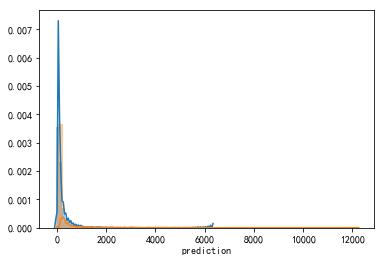

In [1854]:
sns.distplot(pred['prediction']);
sns.distplot(y_test_ns);

In [1855]:
gbm = lgb.LGBMRegressor(alpha=0.9, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=2000, 
                        subsample=0.7,
                        silent=1,
                        seed=0 )

gbm.fit(X_train, y_train.values.T[0], eval_set=(X_test, y_test.values.T[0])) 

[1]	valid_0's l2: 3.42274e-05
[2]	valid_0's l2: 3.22129e-05
[3]	valid_0's l2: 3.04248e-05
[4]	valid_0's l2: 2.87029e-05
[5]	valid_0's l2: 2.73799e-05
[6]	valid_0's l2: 2.62068e-05
[7]	valid_0's l2: 2.52015e-05
[8]	valid_0's l2: 2.4538e-05
[9]	valid_0's l2: 2.39162e-05
[10]	valid_0's l2: 2.33076e-05
[11]	valid_0's l2: 2.27479e-05
[12]	valid_0's l2: 2.24498e-05
[13]	valid_0's l2: 2.18232e-05
[14]	valid_0's l2: 2.13341e-05
[15]	valid_0's l2: 2.0818e-05
[16]	valid_0's l2: 2.05673e-05
[17]	valid_0's l2: 2.04081e-05
[18]	valid_0's l2: 2.03643e-05
[19]	valid_0's l2: 2.03464e-05
[20]	valid_0's l2: 2.02021e-05
[21]	valid_0's l2: 2.01208e-05
[22]	valid_0's l2: 2.01085e-05
[23]	valid_0's l2: 2.01495e-05
[24]	valid_0's l2: 2.01302e-05
[25]	valid_0's l2: 2.03384e-05
[26]	valid_0's l2: 2.04892e-05
[27]	valid_0's l2: 2.04575e-05
[28]	valid_0's l2: 2.05512e-05
[29]	valid_0's l2: 2.06562e-05
[30]	valid_0's l2: 2.07024e-05
[31]	valid_0's l2: 2.0779e-05
[32]	valid_0's l2: 2.08973e-05
[33]	valid_0's l2: 2

[272]	valid_0's l2: 2.44e-05
[273]	valid_0's l2: 2.43966e-05
[274]	valid_0's l2: 2.43959e-05
[275]	valid_0's l2: 2.43922e-05
[276]	valid_0's l2: 2.4386e-05
[277]	valid_0's l2: 2.43859e-05
[278]	valid_0's l2: 2.44497e-05
[279]	valid_0's l2: 2.44461e-05
[280]	valid_0's l2: 2.44472e-05
[281]	valid_0's l2: 2.44438e-05
[282]	valid_0's l2: 2.44422e-05
[283]	valid_0's l2: 2.44362e-05
[284]	valid_0's l2: 2.44221e-05
[285]	valid_0's l2: 2.44219e-05
[286]	valid_0's l2: 2.44201e-05
[287]	valid_0's l2: 2.44041e-05
[288]	valid_0's l2: 2.43912e-05
[289]	valid_0's l2: 2.439e-05
[290]	valid_0's l2: 2.43729e-05
[291]	valid_0's l2: 2.43599e-05
[292]	valid_0's l2: 2.45389e-05
[293]	valid_0's l2: 2.45383e-05
[294]	valid_0's l2: 2.45936e-05
[295]	valid_0's l2: 2.45814e-05
[296]	valid_0's l2: 2.45647e-05
[297]	valid_0's l2: 2.45442e-05
[298]	valid_0's l2: 2.45319e-05
[299]	valid_0's l2: 2.45266e-05
[300]	valid_0's l2: 2.45263e-05
[301]	valid_0's l2: 2.45207e-05
[302]	valid_0's l2: 2.45036e-05
[303]	valid_0'

[544]	valid_0's l2: 2.62594e-05
[545]	valid_0's l2: 2.62567e-05
[546]	valid_0's l2: 2.62553e-05
[547]	valid_0's l2: 2.62576e-05
[548]	valid_0's l2: 2.62562e-05
[549]	valid_0's l2: 2.6253e-05
[550]	valid_0's l2: 2.6255e-05
[551]	valid_0's l2: 2.62375e-05
[552]	valid_0's l2: 2.62213e-05
[553]	valid_0's l2: 2.62132e-05
[554]	valid_0's l2: 2.62143e-05
[555]	valid_0's l2: 2.61997e-05
[556]	valid_0's l2: 2.61965e-05
[557]	valid_0's l2: 2.61956e-05
[558]	valid_0's l2: 2.61924e-05
[559]	valid_0's l2: 2.61934e-05
[560]	valid_0's l2: 2.61994e-05
[561]	valid_0's l2: 2.61793e-05
[562]	valid_0's l2: 2.62621e-05
[563]	valid_0's l2: 2.62556e-05
[564]	valid_0's l2: 2.6215e-05
[565]	valid_0's l2: 2.61965e-05
[566]	valid_0's l2: 2.61905e-05
[567]	valid_0's l2: 2.61753e-05
[568]	valid_0's l2: 2.61589e-05
[569]	valid_0's l2: 2.61387e-05
[570]	valid_0's l2: 2.61614e-05
[571]	valid_0's l2: 2.61447e-05
[572]	valid_0's l2: 2.61289e-05
[573]	valid_0's l2: 2.61247e-05
[574]	valid_0's l2: 2.61241e-05
[575]	valid

[809]	valid_0's l2: 2.62432e-05
[810]	valid_0's l2: 2.62415e-05
[811]	valid_0's l2: 2.62324e-05
[812]	valid_0's l2: 2.62322e-05
[813]	valid_0's l2: 2.62319e-05
[814]	valid_0's l2: 2.6228e-05
[815]	valid_0's l2: 2.62223e-05
[816]	valid_0's l2: 2.62119e-05
[817]	valid_0's l2: 2.62091e-05
[818]	valid_0's l2: 2.62066e-05
[819]	valid_0's l2: 2.61998e-05
[820]	valid_0's l2: 2.61987e-05
[821]	valid_0's l2: 2.61981e-05
[822]	valid_0's l2: 2.61976e-05
[823]	valid_0's l2: 2.61969e-05
[824]	valid_0's l2: 2.6196e-05
[825]	valid_0's l2: 2.61964e-05
[826]	valid_0's l2: 2.61956e-05
[827]	valid_0's l2: 2.61918e-05
[828]	valid_0's l2: 2.61909e-05
[829]	valid_0's l2: 2.61858e-05
[830]	valid_0's l2: 2.61852e-05
[831]	valid_0's l2: 2.61887e-05
[832]	valid_0's l2: 2.61884e-05
[833]	valid_0's l2: 2.61885e-05
[834]	valid_0's l2: 2.6188e-05
[835]	valid_0's l2: 2.61876e-05
[836]	valid_0's l2: 2.61872e-05
[837]	valid_0's l2: 2.61861e-05
[838]	valid_0's l2: 2.6185e-05
[839]	valid_0's l2: 2.61833e-05
[840]	valid_

[1083]	valid_0's l2: 2.73451e-05
[1084]	valid_0's l2: 2.73402e-05
[1085]	valid_0's l2: 2.73378e-05
[1086]	valid_0's l2: 2.73351e-05
[1087]	valid_0's l2: 2.73262e-05
[1088]	valid_0's l2: 2.73215e-05
[1089]	valid_0's l2: 2.73165e-05
[1090]	valid_0's l2: 2.74603e-05
[1091]	valid_0's l2: 2.74591e-05
[1092]	valid_0's l2: 2.74538e-05
[1093]	valid_0's l2: 2.74607e-05
[1094]	valid_0's l2: 2.74559e-05
[1095]	valid_0's l2: 2.75655e-05
[1096]	valid_0's l2: 2.75641e-05
[1097]	valid_0's l2: 2.75562e-05
[1098]	valid_0's l2: 2.75523e-05
[1099]	valid_0's l2: 2.75253e-05
[1100]	valid_0's l2: 2.75072e-05
[1101]	valid_0's l2: 2.75058e-05
[1102]	valid_0's l2: 2.74951e-05
[1103]	valid_0's l2: 2.7492e-05
[1104]	valid_0's l2: 2.74894e-05
[1105]	valid_0's l2: 2.7487e-05
[1106]	valid_0's l2: 2.74786e-05
[1107]	valid_0's l2: 2.85124e-05
[1108]	valid_0's l2: 2.85051e-05
[1109]	valid_0's l2: 2.84769e-05
[1110]	valid_0's l2: 2.84851e-05
[1111]	valid_0's l2: 2.84969e-05
[1112]	valid_0's l2: 2.8495e-05
[1113]	valid_

[1347]	valid_0's l2: 2.91537e-05
[1348]	valid_0's l2: 2.91523e-05
[1349]	valid_0's l2: 2.91513e-05
[1350]	valid_0's l2: 2.91508e-05
[1351]	valid_0's l2: 2.91499e-05
[1352]	valid_0's l2: 2.91484e-05
[1353]	valid_0's l2: 2.91476e-05
[1354]	valid_0's l2: 2.91443e-05
[1355]	valid_0's l2: 2.91432e-05
[1356]	valid_0's l2: 2.91424e-05
[1357]	valid_0's l2: 2.91404e-05
[1358]	valid_0's l2: 2.91379e-05
[1359]	valid_0's l2: 2.91368e-05
[1360]	valid_0's l2: 2.91344e-05
[1361]	valid_0's l2: 2.91335e-05
[1362]	valid_0's l2: 2.91227e-05
[1363]	valid_0's l2: 2.91231e-05
[1364]	valid_0's l2: 2.91193e-05
[1365]	valid_0's l2: 2.91111e-05
[1366]	valid_0's l2: 2.9109e-05
[1367]	valid_0's l2: 2.91109e-05
[1368]	valid_0's l2: 2.91035e-05
[1369]	valid_0's l2: 2.91019e-05
[1370]	valid_0's l2: 2.90992e-05
[1371]	valid_0's l2: 2.90984e-05
[1372]	valid_0's l2: 2.90986e-05
[1373]	valid_0's l2: 2.91351e-05
[1374]	valid_0's l2: 2.91343e-05
[1375]	valid_0's l2: 2.91331e-05
[1376]	valid_0's l2: 2.91321e-05
[1377]	vali

[1614]	valid_0's l2: 2.99386e-05
[1615]	valid_0's l2: 2.99379e-05
[1616]	valid_0's l2: 2.99379e-05
[1617]	valid_0's l2: 2.99373e-05
[1618]	valid_0's l2: 2.99367e-05
[1619]	valid_0's l2: 2.99361e-05
[1620]	valid_0's l2: 2.99355e-05
[1621]	valid_0's l2: 2.9934e-05
[1622]	valid_0's l2: 2.99331e-05
[1623]	valid_0's l2: 2.99325e-05
[1624]	valid_0's l2: 2.99314e-05
[1625]	valid_0's l2: 2.99304e-05
[1626]	valid_0's l2: 2.99283e-05
[1627]	valid_0's l2: 2.99339e-05
[1628]	valid_0's l2: 2.99329e-05
[1629]	valid_0's l2: 2.99322e-05
[1630]	valid_0's l2: 2.99498e-05
[1631]	valid_0's l2: 2.9951e-05
[1632]	valid_0's l2: 2.99431e-05
[1633]	valid_0's l2: 2.99395e-05
[1634]	valid_0's l2: 2.99348e-05
[1635]	valid_0's l2: 2.99302e-05
[1636]	valid_0's l2: 2.99275e-05
[1637]	valid_0's l2: 2.99244e-05
[1638]	valid_0's l2: 2.99212e-05
[1639]	valid_0's l2: 2.9919e-05
[1640]	valid_0's l2: 2.99075e-05
[1641]	valid_0's l2: 2.99058e-05
[1642]	valid_0's l2: 2.99029e-05
[1643]	valid_0's l2: 2.99019e-05
[1644]	valid_

[1875]	valid_0's l2: 2.98384e-05
[1876]	valid_0's l2: 2.98373e-05
[1877]	valid_0's l2: 2.98355e-05
[1878]	valid_0's l2: 2.98352e-05
[1879]	valid_0's l2: 2.98349e-05
[1880]	valid_0's l2: 2.9834e-05
[1881]	valid_0's l2: 2.98337e-05
[1882]	valid_0's l2: 2.98501e-05
[1883]	valid_0's l2: 2.98501e-05
[1884]	valid_0's l2: 2.99289e-05
[1885]	valid_0's l2: 2.99282e-05
[1886]	valid_0's l2: 2.99271e-05
[1887]	valid_0's l2: 2.99263e-05
[1888]	valid_0's l2: 2.99249e-05
[1889]	valid_0's l2: 2.99241e-05
[1890]	valid_0's l2: 2.9925e-05
[1891]	valid_0's l2: 2.99263e-05
[1892]	valid_0's l2: 2.99258e-05
[1893]	valid_0's l2: 2.99273e-05
[1894]	valid_0's l2: 2.99285e-05
[1895]	valid_0's l2: 3.0079e-05
[1896]	valid_0's l2: 3.00792e-05
[1897]	valid_0's l2: 3.00771e-05
[1898]	valid_0's l2: 3.00762e-05
[1899]	valid_0's l2: 3.00746e-05
[1900]	valid_0's l2: 3.00742e-05
[1901]	valid_0's l2: 3.0072e-05
[1902]	valid_0's l2: 3.00701e-05
[1903]	valid_0's l2: 3.00686e-05
[1904]	valid_0's l2: 3.00668e-05
[1905]	valid_0

LGBMRegressor(alpha=0.9, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=31, objective='quantile',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=0, silent=1,
       subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [1856]:
gbm_pred=gbm.predict(X_test) 

In [1857]:
gbm_pred = pd.DataFrame(y_scaler.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['prediction']).fillna(0)
# gbm_pred = pd.DataFrame(gbm_pred.reshape(-1, 1), columns=['prediction']).fillna(0)

In [1858]:
h = 1
b = 9

In [1859]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)


In [1860]:
o4['actual_pur_qtty'];
o4['overall_opt_order_for_opt'];

In [1861]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

In [1862]:
o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [1863]:
# list_c = ['SKU_DC', 'create_tm', 'OPT', 'E2E_NN', 'E2E_GBM', 'EQ',  'Normal', 'Gamma', 'Hist', 
#           'Ave_sales','Std_sales', 
# #           'Ave_review', 'Std_review'
#          ]
# numberOfRows = len(o4)

# df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
# df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
# df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
# df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
# df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [1864]:
# df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
# df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
# df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
# df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [1865]:
o4['gbm_pred'] = (gbm_pred['prediction'] - o4['initial_stock']).clip(0)
# o4['gbm_pred'] = gbm_pred['prediction'].clip(0)
o4['E2E_GBM_inv_f'], o4['E2E_GBM_inv'] = zip(*o4.apply(get_inv, name='gbm_pred',  axis=1))

o4['nn_pred'] = (pred['prediction'] - o4['initial_stock']).clip(0)
# o4['nn_pred'] = pred['prediction'].clip(0)
o4['E2E_NN_inv_f'], o4['E2E_NN_inv'] = zip(*o4.apply(get_inv, name='nn_pred', axis=1))

In [1866]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]
    
    
o4['OPT_inv_f'], o4['OPT_inv'] = zip(*o4.apply(lambda x: get_inv(x, 'target_decision'), axis=1))

o4['EQ_replen'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_replen'] = (o4['EQ_replen'] - o4['initial_stock']).clip(0)
o4['EQ_inv_f'], o4['EQ_inv'] = zip(*o4.apply(get_inv, name='EQ_replen', axis=1))

o4['Normal_replen'] = o4.apply(lambda x: int(x['mean_112']*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)
o4['Normal_replen'] = (o4['Normal_replen'] - o4['initial_stock']).clip(0)
o4['Normal_inv_f'], o4['Normal_inv'] = zip(*o4.apply(get_inv, name='Normal_replen',  axis=1))

def gamma_base(x):
    mean = x['mean_112']
    var = x['std_140']**2
    theta = var/(mean+1e-5)
    k = mean/(theta+1e-5)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_replen'] = o4.apply(gamma_base, axis=1)
o4['Gamma_replen'] = (o4['Gamma_replen'] - o4['initial_stock']).clip(0)
o4['Gamma_inv_f'],o4['Gamma_inv'] = zip(*o4.apply(get_inv, name='Gamma_replen', axis=1))

o4['Hist_inv_f'], o4['Hist_inv'] = zip(*o4.apply(get_inv, name='actual_pur_qtty', axis=1))


In [1867]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'] = o4['EQ_replen_with_IS'] - o4['initial_stock_overall']
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
# o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [1868]:
str_list = ['OPT', 'E2E_NN', 'E2E_GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
#     df_back[str1] = o4[str2].apply(lambda x: b * sum([-inv for inv in x if inv<0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * (0 if  x==[] else max(0, -x[-1])))
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df_turnover[str1] = o4.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112']
                                  if np.mean(x['mean_112']) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [1869]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

,E2E_NN,Hist,E2E_GBM,EQ,Normal,Gamma
Best,0.296087,0.241896,0.209398,0.114849,0.071136,0.066634


In [1870]:
pd.DataFrame({'Total': df_cost[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','E2E_NN','E2E_GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,E2E_NN,E2E_GBM,EQ,Normal,Gamma,Hist,Ave_sales
Total,1255.762688,1998.686175,1742.029055,3336.044270,2409.321791,2352.972086,2003.831205,24.441725
Holding,1255.762688,1636.792609,1248.271138,2882.032580,2112.696054,2034.851261,1550.835625,24.441725
Back,0.000000,361.893566,493.757916,454.011690,296.625737,318.120825,452.995580,24.441725
Stockout,0.000000,0.084950,0.182437,0.154964,0.090638,0.103153,0.233990,24.441725
Turnover,6.817423,19.787817,10.014392,65.343854,13.318790,12.761750,10.839532,24.441725


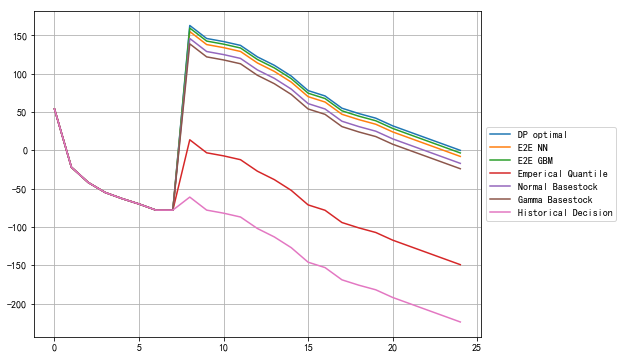

In [1871]:
tt = o4.iloc[305,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_inv_f'], label = 'DP optimal')
ax1.plot(tt['E2E_NN_inv_f'], label = 'E2E NN')
ax1.plot(tt['E2E_GBM_inv_f'], label = 'E2E GBM')
ax1.plot(tt['EQ_inv_f'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_inv_f'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_inv_f'], label = 'Gamma Basestock')
ax1.plot(tt['Hist_inv_f'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.grid(True)

In [1872]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

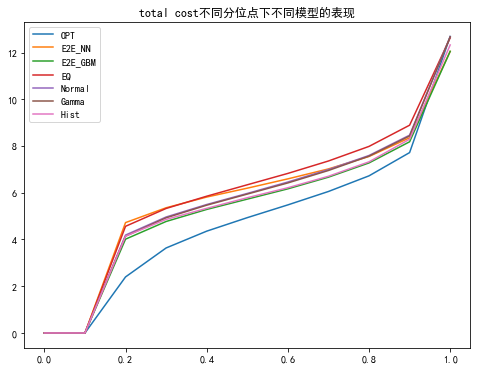

In [1873]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('total cost不同分位点下不同模型的表现');

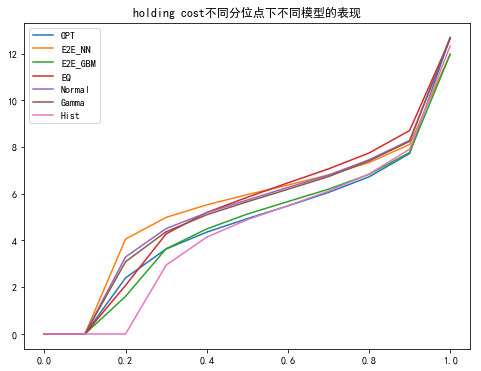

In [1874]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

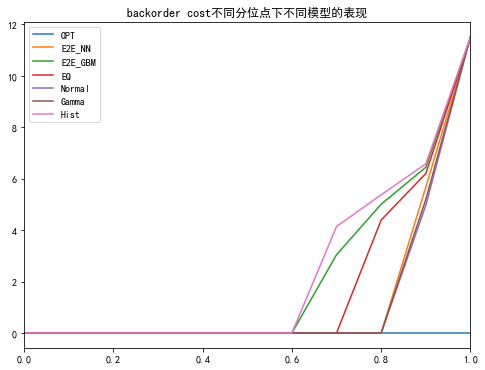

In [1875]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('backorder cost不同分位点下不同模型的表现');

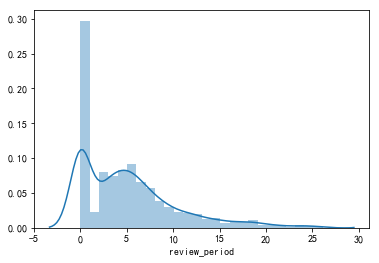

In [1876]:
# sns.distplot(np.log(df_cost['Ave_sales']));
sns.distplot(o4.groupby('item_sku_id').review_period.std().fillna(0))

In [1877]:
# py_pp = df_cost
# py_pp['SKU_DC'] = py_pp[['SKU_DC','create_tm']].apply(lambda x: '_'.join([str(i) for i in x]), axis=1)
# py_pp.drop(columns=['create_tm','Ave_sales','Std_sales'], inplace=True)
# py_pp_stack = py_pp.set_index('SKU_DC').stack().rename('method')
# py_pp_stack = pd.DataFrame(py_pp_stack).reset_index()
# taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(py_pp_stack.iloc[0:770,:], ['SKU_DC'], ['method'], ['level_1'])
# optperfprofpy.draw_simple_pp(taus, solver_vals, solvers)

In [1878]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [1879]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

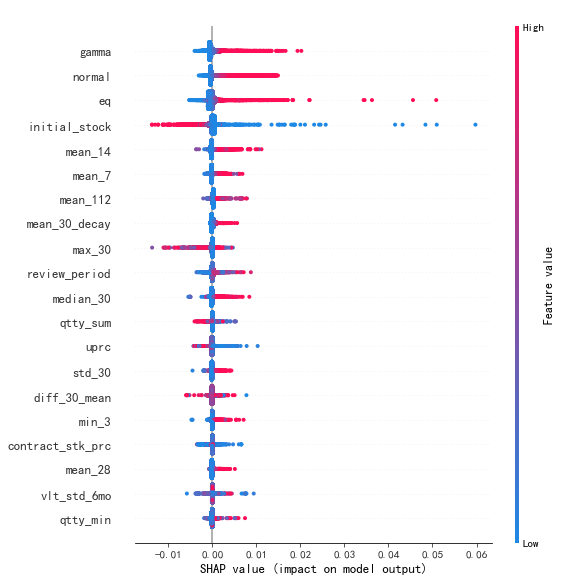

In [1880]:
shap.summary_plot(shap_values, X_test)

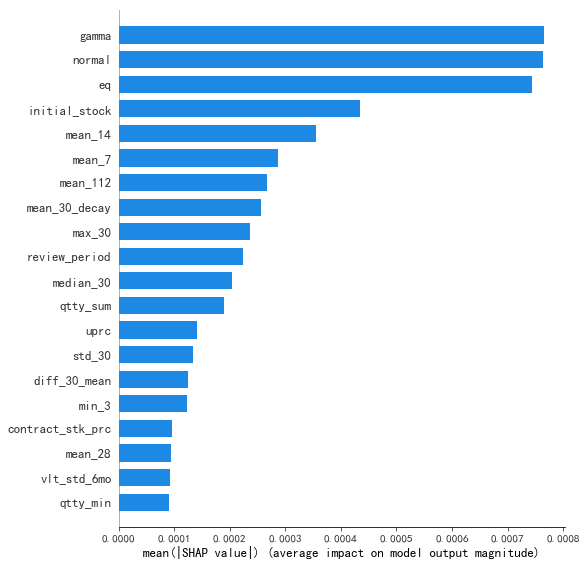

In [1881]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [1882]:
xx = np.arange(0,0.2,0.01)
tt_is = X_test.iloc[305:306,:]
yy1, yy2 = [],[]
for i in xx:
    tt_is['initial_stock'] = i
    gbm_pred=gbm.predict(tt_is) 
    nn_pred=sess.run(output, feed_dict={x_vlt: tt_is[VLT_FEA].values, 
                                  x_sf: tt_is[SF_FEA].values, 
                                  x_oth: tt_is[MORE_FEA].values, 
                                  x_is: tt_is[IS_FEA].values, 
                                  })
    yy1.append( y_scaler.inverse_transform(gbm_pred.reshape(-1, 1))[0][0] )
    yy2.append( y_scaler.inverse_transform(nn_pred.reshape(-1, 1))[0][0]+50 )

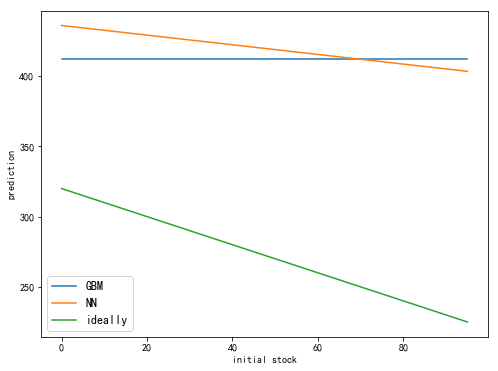

In [1883]:
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(xx*500, yy1, label='GBM');
plt.plot(xx*500, yy2, label='NN');
plt.plot(xx*500, 320-xx*500, label='ideally');

# plt.plot(xx, 330-xx)
plt.xlabel('initial stock')
plt.ylabel('prediction')
plt.legend(prop={'size': 12})

In [ ]:
sess.close()